# Initialization

---



Importing necessary libraries

In [ ]:
pip install findspark
pip install pyspark

In [814]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, NumericType
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from pyspark.sql import functions as F
from pyspark.sql import DataFrame
from typing import List, Dict
from pyspark.sql import Window
import pandas as pd
import string
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import unittest
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/neharajput/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/neharajput/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Create spark session

In [815]:
spark = SparkSession.builder. \
    appName("DE-assessment").\
    getOrCreate()

# Data Preprocessing

In [816]:
nyc_jobs_raw=spark.read.option("delimiter", ",").csv('/Users/neharajput/Downloads/nyc-jobs_new.csv', header=True, inferSchema=True)
nyc_jobs_raw.printSchema()

root
 |-- Job_ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting_Type: string (nullable = true)
 |-- #_Of_Positions: integer (nullable = true)
 |-- Business_Title: string (nullable = true)
 |-- Civil_Service_Title: string (nullable = true)
 |-- Title_Code_No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job_Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary_Range_From: double (nullable = true)
 |-- Salary_Range_To: double (nullable = true)
 |-- Salary_Frequency: string (nullable = true)
 |-- Work_Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job_Description: string (nullable = true)
 |-- Minimum_Qual_Requirements: string (nullable = true)
 |-- Preferred_Skills: string (nullable = true)
 |-- Additional_Information: string (nullable = true)
 |-- To_Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work_Locat

In [817]:
nyc_jobs_raw

DataFrame[Job_ID: int, Agency: string, Posting_Type: string, #_Of_Positions: int, Business_Title: string, Civil_Service_Title: string, Title_Code_No: string, Level: string, Job_Category: string, Full-Time/Part-Time indicator: string, Salary_Range_From: double, Salary_Range_To: double, Salary_Frequency: string, Work_Location: string, Division/Work Unit: string, Job_Description: string, Minimum_Qual_Requirements: string, Preferred_Skills: string, Additional_Information: string, To_Apply: string, Hours/Shift: string, Work_Location_1: string, Recruitment_Contact: string, Residency_Requirement: string, Posting_Date: timestamp, Post_Until: timestamp, Posting_Updated: timestamp, Process_Date: timestamp]

1. Drop Duplicate rows

In [818]:
nyc_jobs_raw.count()

2946

In [819]:
nyc_jobs_raw=nyc_jobs_raw.drop_duplicates()
nyc_jobs_raw.count()

2915

**We've dropped 31 rows which were exact duplicate**

2. Basic Analysis

In [820]:
num_rows = nyc_jobs_raw.count()
num_columns = len(nyc_jobs_raw.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 2915
Number of columns: 28


3. Missing value analysis

Text(0.5, 1.0, 'Number of Missing Values for Each Column of Our Data Set')

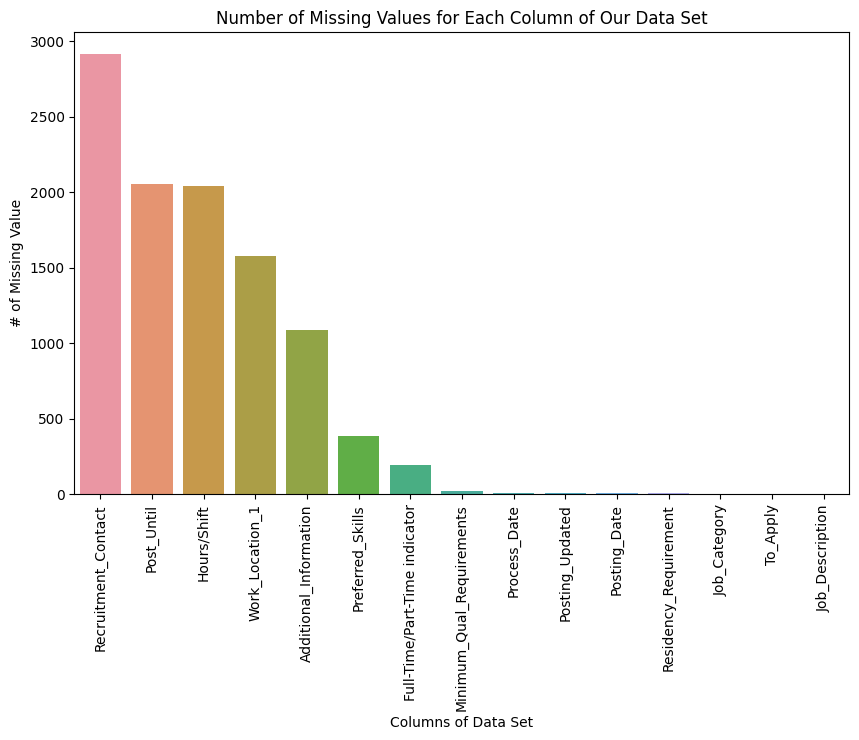

In [821]:
missing_val_table=nyc_jobs_raw.select([(F.count(F.when(F.col(c).isNull(), c))).alias(c) for c in nyc_jobs_raw.columns]).toPandas().T
missing_val_table.reset_index(inplace=True)
missing_val_table.columns=['column_name','count_of_missing']
missing_val_table=missing_val_table.sort_values('count_of_missing',ascending=False).head(15)

plt.figure(figsize = (10,6))
ax = sns.barplot(x = missing_val_table["column_name"],y = missing_val_table["count_of_missing"])
plt.xticks(rotation = 90)
plt.yticks()
plt.xlabel("Columns of Data Set")
plt.ylabel("# of Missing Value")
plt.title("Number of Missing Values for Each Column of Our Data Set")

As we can see, column Recruitment_contact is empty so we'll be dropping it from analysis. Most of the values of Post_Until is missing as well, so will be dropping it from the dataframe

In [822]:
nyc_jobs_raw=nyc_jobs_raw.drop('Recruitment_Contact','Post_Until')

# Analysis

In [823]:
# Characters columns
categorical_columns = [col for col, dtype in nyc_jobs_raw.dtypes if dtype == 'string']
# Numerical columns
numerical_columns = [col for col, dtype in nyc_jobs_raw.dtypes if isinstance(nyc_jobs_raw.schema[col].dataType, NumericType)]

print(f"Categorical Columns: {categorical_columns}")
print(f"Numerical Columns: {numerical_columns}")

Categorical Columns: ['Agency', 'Posting_Type', 'Business_Title', 'Civil_Service_Title', 'Title_Code_No', 'Level', 'Job_Category', 'Full-Time/Part-Time indicator', 'Salary_Frequency', 'Work_Location', 'Division/Work Unit', 'Job_Description', 'Minimum_Qual_Requirements', 'Preferred_Skills', 'Additional_Information', 'To_Apply', 'Hours/Shift', 'Work_Location_1', 'Residency_Requirement']
Numerical Columns: ['Job_ID', '#_Of_Positions', 'Salary_Range_From', 'Salary_Range_To']


JOB_ID should be a categorical column so we're converting it into string

In [824]:
nyc_jobs_raw = nyc_jobs_raw.withColumn("Job_ID", F.col("Job_ID").cast("string"))

Also, not all string based columns are categorical, some of them have text based data so they should be treated separately

In [825]:
# Characters columns
categorical_columns = [col for col, dtype in nyc_jobs_raw.dtypes if dtype == 'string']
# Numerical columns
numerical_columns = [col for col, dtype in nyc_jobs_raw.dtypes if isinstance(nyc_jobs_raw.schema[col].dataType, NumericType)]

text_columns =[ 'Job_Description', 'Minimum_Qual_Requirements', 'Preferred_Skills',
               'Additional_Information', 'To_Apply','Residency_Requirement','Hours/Shift']

categorical_columns=[x for x in categorical_columns if x not in text_columns]
print(f"Categorical Columns: {categorical_columns}")
print(f"Numerical Columns: {numerical_columns}")
print(f"Text Columns: {text_columns}")

Categorical Columns: ['Job_ID', 'Agency', 'Posting_Type', 'Business_Title', 'Civil_Service_Title', 'Title_Code_No', 'Level', 'Job_Category', 'Full-Time/Part-Time indicator', 'Salary_Frequency', 'Work_Location', 'Division/Work Unit', 'Work_Location_1']
Numerical Columns: ['#_Of_Positions', 'Salary_Range_From', 'Salary_Range_To']
Text Columns: ['Job_Description', 'Minimum_Qual_Requirements', 'Preferred_Skills', 'Additional_Information', 'To_Apply', 'Residency_Requirement', 'Hours/Shift']


**Summary of Numerical variables**

In [826]:
nyc_jobs_raw.describe(numerical_columns).show()

+-------+------------------+------------------+-----------------+
|summary|    #_Of_Positions| Salary_Range_From|  Salary_Range_To|
+-------+------------------+------------------+-----------------+
|  count|              2915|              2915|             2915|
|   mean|2.4363636363636365|58925.987438319025|85653.82161382504|
| stddev| 8.581054962767546| 27018.91541580618|42923.02678547604|
|    min|                 1|               0.0|            10.36|
|    max|               200|          218587.0|         234402.0|
+-------+------------------+------------------+-----------------+



**Summary of Categorical columns**

In [827]:
print("Column name : Unique values")
for col in categorical_columns:
    unique_count = nyc_jobs_raw.select(col).distinct().count()
    print(f"{col} : {unique_count} ")

Column name : Unique values
Job_ID : 1661 
Agency : 52 
Posting_Type : 2 
Business_Title : 1244 
Civil_Service_Title : 312 
Title_Code_No : 323 
Level : 14 
Job_Category : 131 
Full-Time/Part-Time indicator : 3 
Salary_Frequency : 3 
Work_Location : 226 
Division/Work Unit : 678 
Work_Location_1 : 228 


**Function to show summary statistics of categorical columns**

In [828]:
def dist_categorical(inp_df,col,top):
  top_categories_pd = inp_df.groupBy(col).count().orderBy('count', ascending=False).limit(top).toPandas()
  #print(top_categories_pd)
  plt.figure(figsize=(8,4))
  sns.barplot(x=col, y="count", data=top_categories_pd, palette="viridis")
  title="Top 10 "+ col + " by Frequency"
  plt.title(title)
  plt.xlabel(col)
  plt.ylabel("Frequency")
  plt.xticks(rotation=90)
  plt.show()

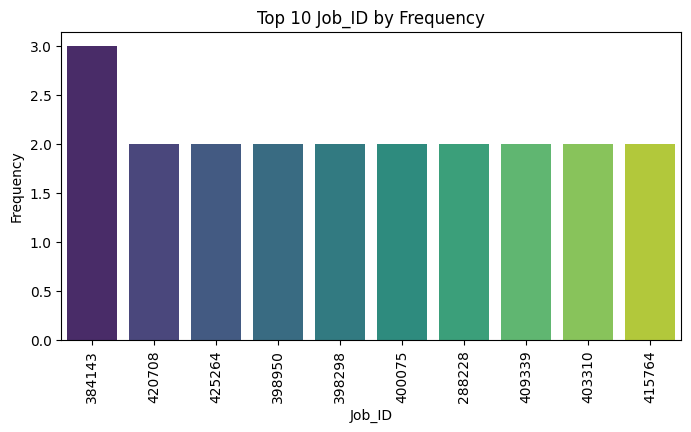

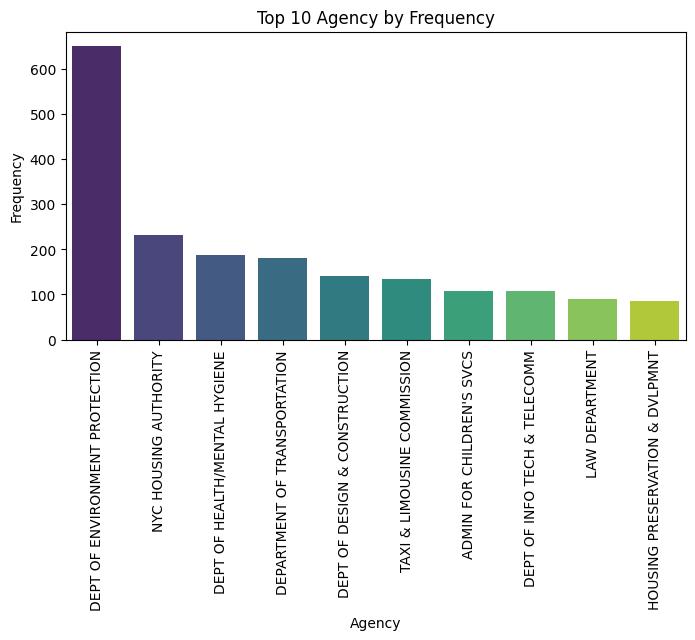

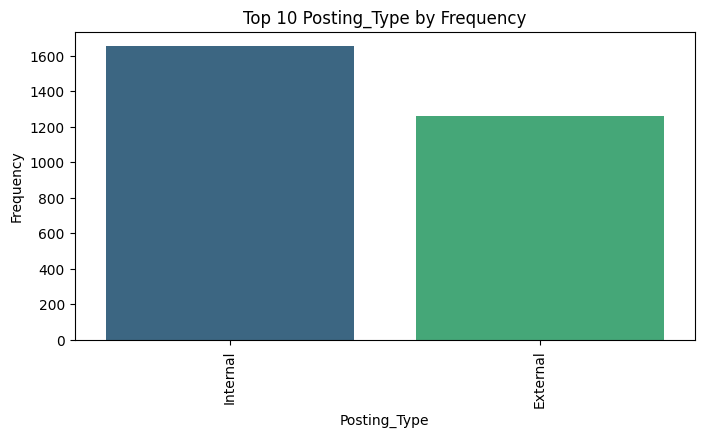

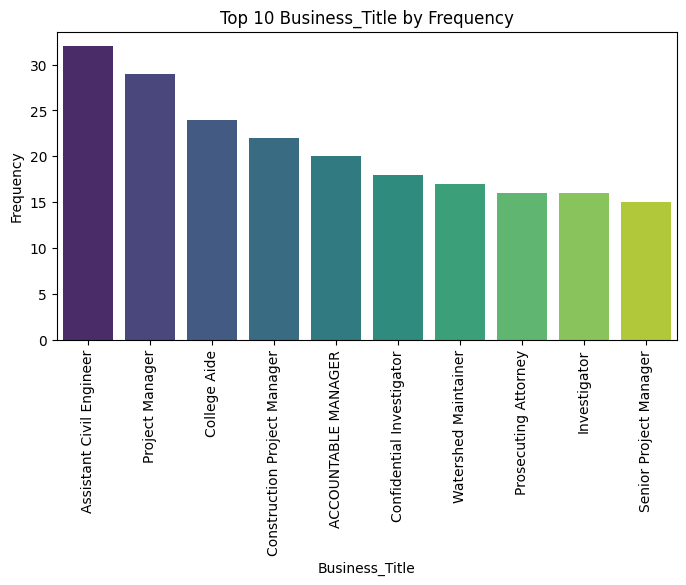

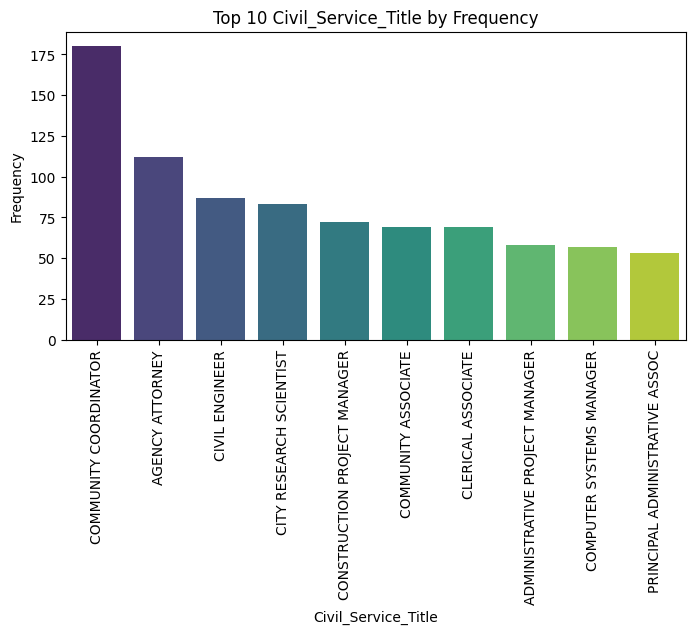

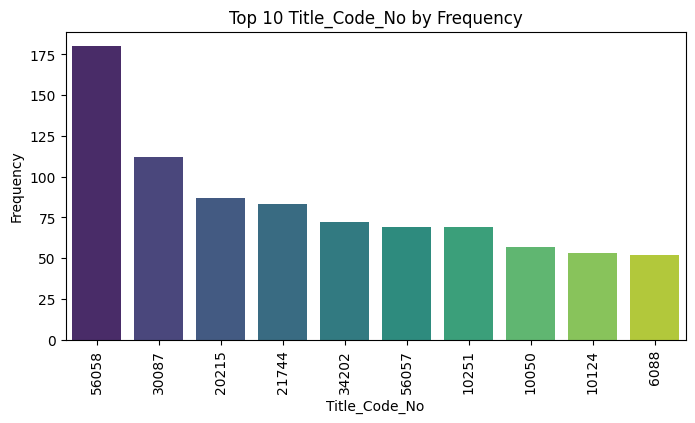

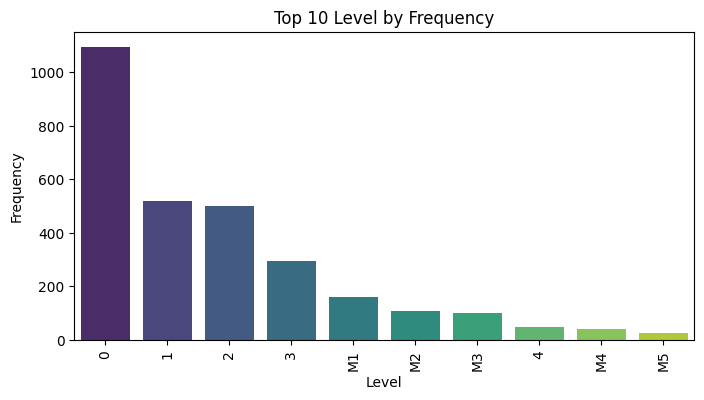

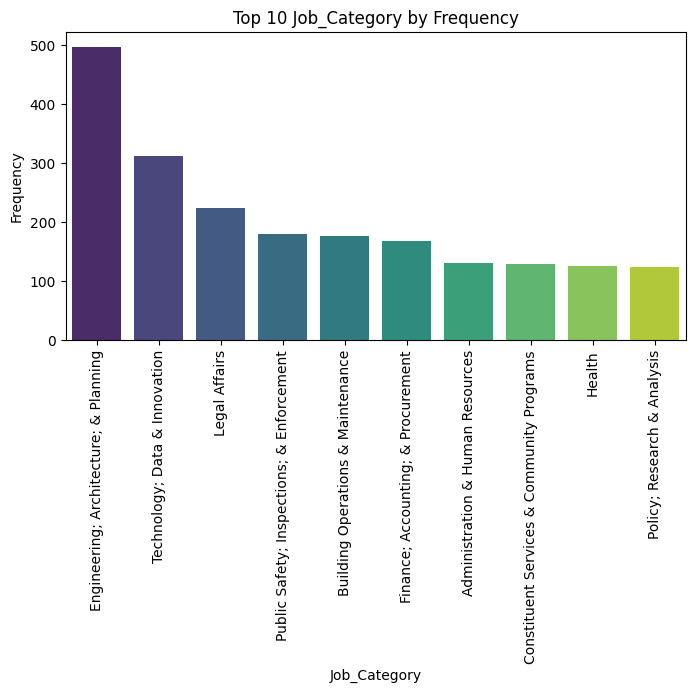

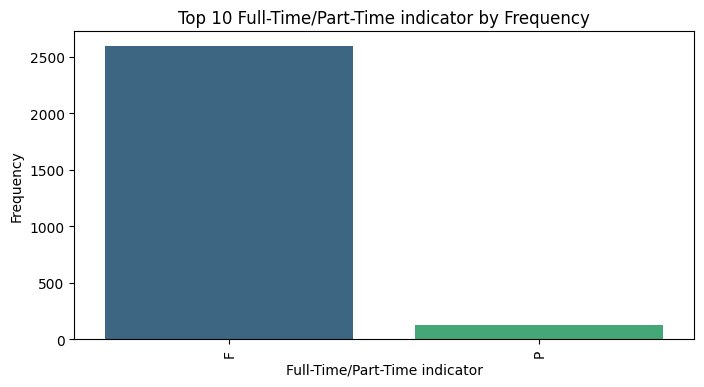

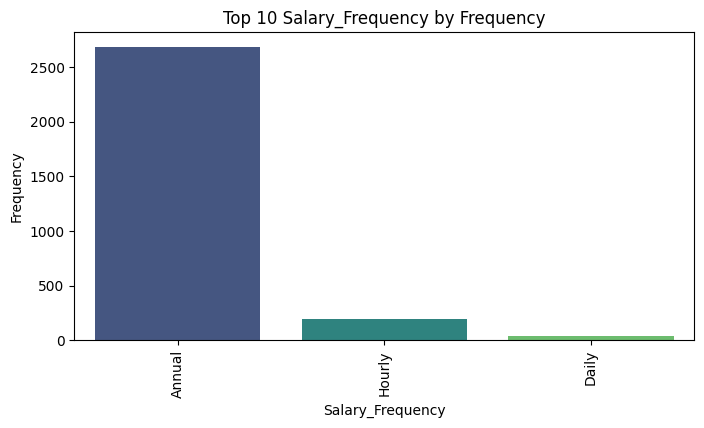

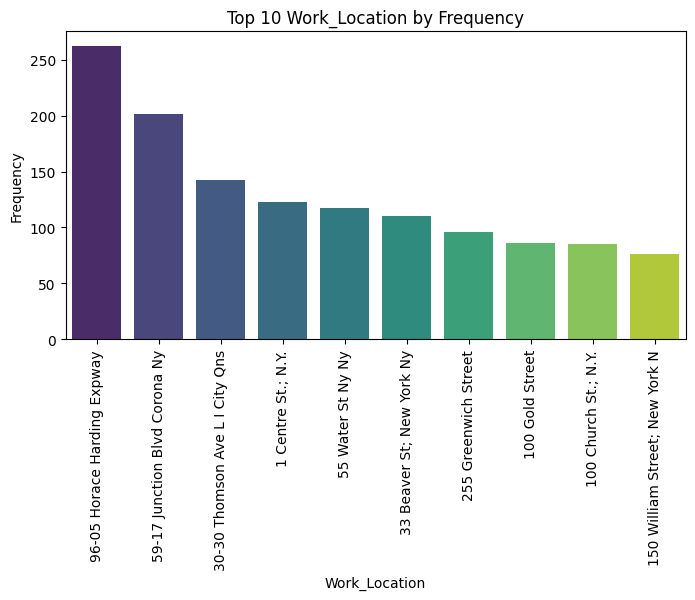

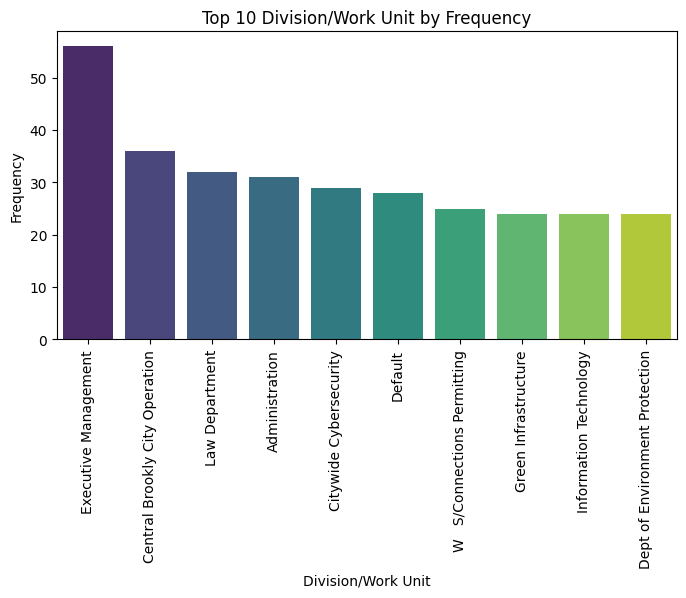

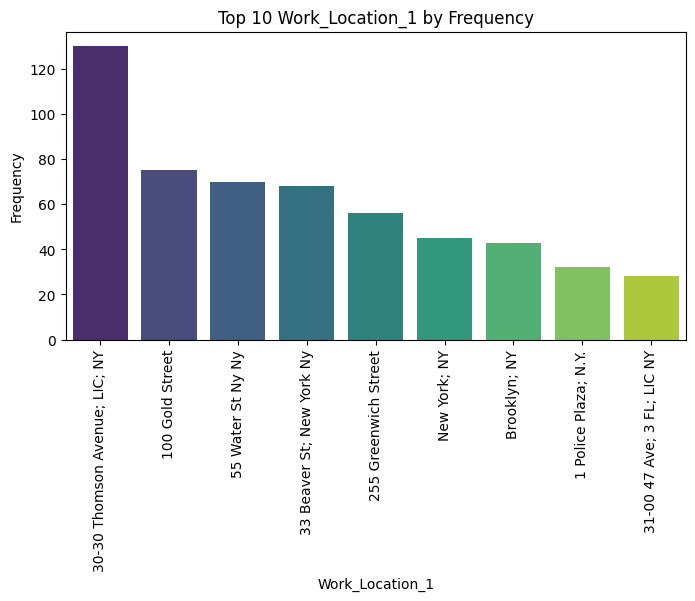

In [829]:
for col in categorical_columns:
  #print(f"Distribution of values in column '{col}':")
   dist_categorical(nyc_jobs_raw,col,10)


Plotting the agency distribution as pie chart for top 20

<AxesSubplot:ylabel='None'>

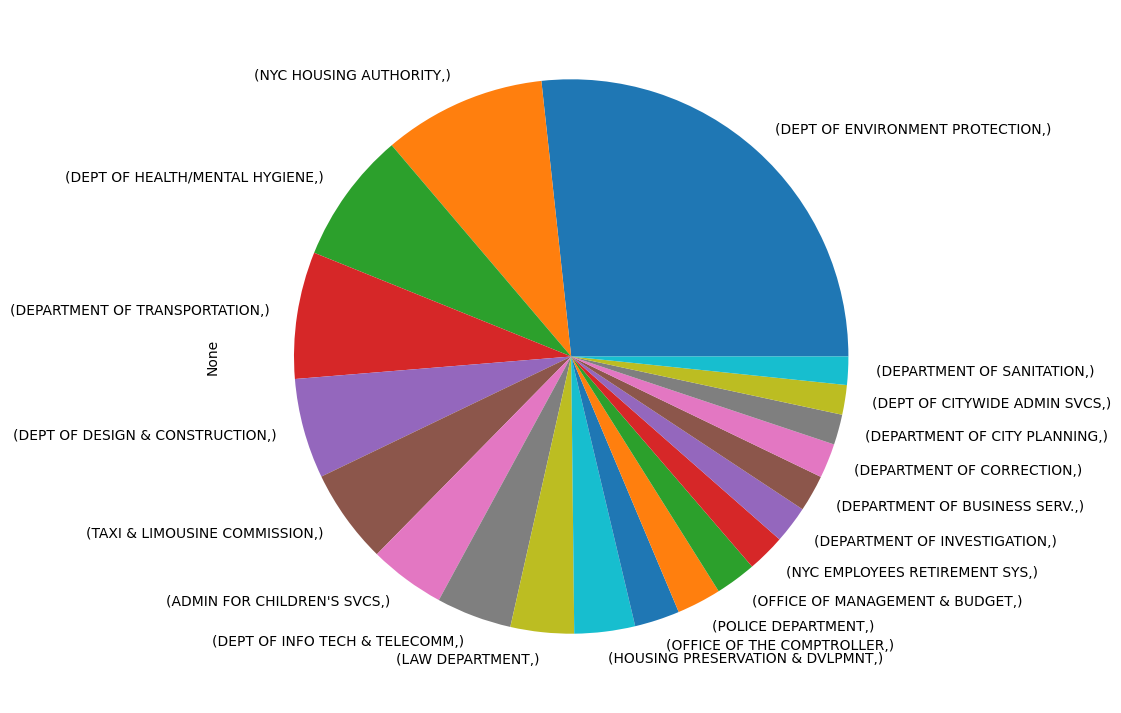

In [830]:
#plotting the agency distribution as pie chart for top 20
nyc_jobs_raw.select('Agency').toPandas().value_counts().head(20).plot(kind='pie',figsize=(9,9))

Count the unique value of all columns

In [832]:
def value_counts_multiple_columns(df: DataFrame, columns: List[str]):
    value_counts_dict = {}
    for col in columns:
        # Calculate value counts for each column
        value_counts_df = df.groupBy(col).count().orderBy("count", ascending=False)
        value_counts_dict[col] = value_counts_df
    return value_counts_dict
# Example usage
columns_to_count = [col for col in nyc_jobs_raw.columns]
value_counts_results = value_counts_multiple_columns(nyc_jobs_raw, columns_to_count)

# To display the result for each column
for col, vc_df in value_counts_results.items():
    print(f"Value counts for {col}:")
    vc_df.show()

Value counts for Job_ID:
+------+-----+
|Job_ID|count|
+------+-----+
|384143|    3|
|390413|    2|
|366241|    2|
|395989|    2|
|412318|    2|
|400075|    2|
|393321|    2|
|409339|    2|
|421214|    2|
|403310|    2|
|395339|    2|
|423960|    2|
|421783|    2|
|410525|    2|
|381492|    2|
|420708|    2|
|288228|    2|
|423010|    2|
|415764|    2|
|289688|    2|
+------+-----+
only showing top 20 rows

Value counts for Agency:
+--------------------+-----+
|              Agency|count|
+--------------------+-----+
|DEPT OF ENVIRONME...|  650|
|NYC HOUSING AUTHO...|  231|
|DEPT OF HEALTH/ME...|  187|
|DEPARTMENT OF TRA...|  180|
|DEPT OF DESIGN & ...|  142|
|TAXI & LIMOUSINE ...|  134|
|ADMIN FOR CHILDRE...|  108|
|DEPT OF INFO TECH...|  107|
|      LAW DEPARTMENT|   90|
|HOUSING PRESERVAT...|   86|
|OFFICE OF THE COM...|   64|
|   POLICE DEPARTMENT|   63|
|OFFICE OF MANAGEM...|   58|
|NYC EMPLOYEES RET...|   54|
|DEPARTMENT OF INV...|   53|
|DEPARTMENT OF BUS...|   52|
|DEPARTMENT O

+--------------------+-----+
|     Job_Description|count|
+--------------------+-----+
|The New York City...|   14|
|The New York City...|    6|
|The New York City...|    4|
|Central communica...|    4|
|The NYC Departmen...|    4|
|The New York City...|    4|
|Under supervision...|    4|
|The NYC Departmen...|    4|
|The NYC Departmen...|    4|
|The New York City...|    4|
|The NYC Departmen...|    4|
|New York City is ...|    4|
|"The NYC Departme...|    4|
|The TLC is lookin...|    4|
|The New York City...|    4|
|Under the general...|    4|
|The New York City...|    4|
|Serve as Project ...|    4|
|New York City is ...|    4|
|The mission of th...|    4|
+--------------------+-----+
only showing top 20 rows

Value counts for Minimum_Qual_Requirements:
+-------------------------+-----+
|Minimum_Qual_Requirements|count|
+-------------------------+-----+
|     "1. A baccalaurea...|  180|
|     "1. Admission to ...|  112|
|     "(1) Four (4) yea...|   87|
|     "1.  For Assignme...|   

# Feature Engineering

**Feature 1**

From Salary frequency column, we can see that there are three categories and we need to move them to same level.

we have decided to move all salary data to annual level.

**Logic**:

1. For Full time Houly salary: multiple by 5 * 8 * 52
2. For Full time Daily salary: multiple by 5 * 52
3. For Part time Houly salary: multiple by 3 * 8 * 52
4. For Part time Daily salary: multiple by 3 * 52

In [833]:
def convert_salary_to_annual(df):
    """
    Convert hourly and daily salaries to annual salaries for both full-time (F) and part-time (P) indicators.

    Parameters:
    df (DataFrame): Input DataFrame containing salary information.

    Returns:
    DataFrame: Updated DataFrame with annual salaries.
    """

    # Step 1: Convert full-time salaries
    df_full_time = df.filter((F.col("Full-Time/Part-Time indicator") == "F") &
                             (F.col("Salary_Frequency").isin("Hourly", "Daily")))

    df_full_time_converted = df_full_time.withColumn(
        "Salary_Range_From_normalized",
        F.when(F.col("Salary_Frequency") == "Hourly", F.col("Salary_Range_From") * 5 * 8 * 52)  # Full-time: 5 days a week, 8 hours a day
        .when(F.col("Salary_Frequency") == "Daily", F.col("Salary_Range_From") * 5 * 52)  # Full-time: 5 days a week
        .otherwise(F.col("Salary_Range_From"))  # Keep original if not hourly or daily
    ).withColumn(
        "Salary_Range_To_normalized",
        F.when(F.col("Salary_Frequency") == "Hourly", F.col("Salary_Range_To") * 5 * 8 * 52)  # Full-time: 5 days a week, 8 hours a day
        .when(F.col("Salary_Frequency") == "Daily", F.col("Salary_Range_To") * 5 * 52)  # Full-time: 5 days a week
        .otherwise(F.col("Salary_Range_To"))  # Keep original if not hourly or daily
    ).withColumn(
        "Salary_Frequency_normalized",
        F.when(F.col("Salary_Frequency").isin("Hourly", "Daily"), "Annual").otherwise(F.col("Salary_Frequency"))  # Convert to annually
    )


    # Step 2: Convert part-time salaries
    df_part_time = df.filter((F.col("Full-Time/Part-Time indicator") == "P") &
                             (F.col("Salary_Frequency").isin("Hourly", "Daily")))

    df_part_time_converted = df_part_time.withColumn(
        "Salary_Range_From_normalized",
        F.when(F.col("Salary_Frequency") == "Hourly", F.col("Salary_Range_From") * 3 * 8 * 52)  # Part-time: 3 days a week, 8 hours a day
        .when(F.col("Salary_Frequency") == "Daily", F.col("Salary_Range_From") * 3 * 52)  # Part-time: 3 days a week
        .otherwise(F.col("Salary_Range_From"))  # Keep original if not hourly or daily
    ).withColumn(
        "Salary_Range_To_normalized",
        F.when(F.col("Salary_Frequency") == "Hourly", F.col("Salary_Range_To") * 3 * 8 * 52)  # Part-time: 3 days a week, 8 hours a day
        .when(F.col("Salary_Frequency") == "Daily", F.col("Salary_Range_To") * 3 * 52)  # Part-time: 3 days a week
        .otherwise(F.col("Salary_Range_To"))  # Keep original if not hourly or daily
    ).withColumn(
        "Salary_Frequency_normalized",
        F.when(F.col("Salary_Frequency").isin("Hourly", "Daily"), "Annual").otherwise(F.col("Salary_Frequency"))  # Convert to annual
    )

    # step 3: Anual salaries, keep them as it is
    df_annual = df.filter(~F.col("Salary_Frequency").isin("Hourly", "Daily"))

    df_annual_converted = df_annual.withColumn(
        "Salary_Range_From_normalized",F.col("Salary_Range_From")  # Keep original if not hourly or daily
    ).withColumn(
        "Salary_Range_To_normalized",F.col("Salary_Range_To")  # Keep original if not hourly or daily
    ).withColumn(
        "Salary_Frequency_normalized", F.col("Salary_Frequency")  # Convert to annual
    )

    # Step 3: Combine both converted DataFrames with the original DataFrame excluding filtered rows
    df_final = df_full_time_converted.union(df_part_time_converted).union(df_annual_converted)

    return df_final




In [834]:
nyc_jobs_salary = convert_salary_to_annual(nyc_jobs_raw)
nyc_jobs_salary= nyc_jobs_salary.na.drop(subset=["Minimum_Qual_Requirements",'Preferred_Skills'])

Distribution of numerical columns

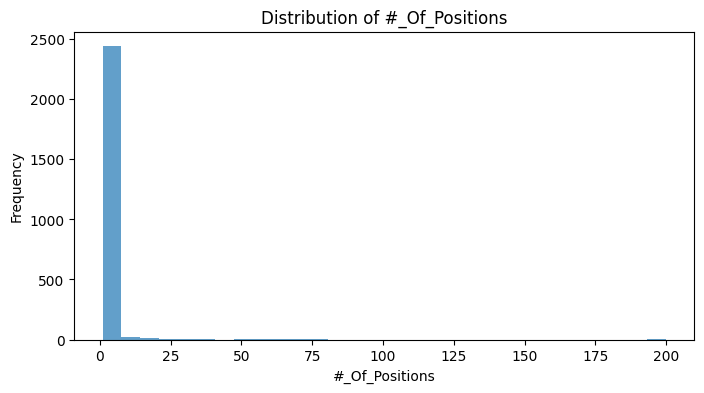

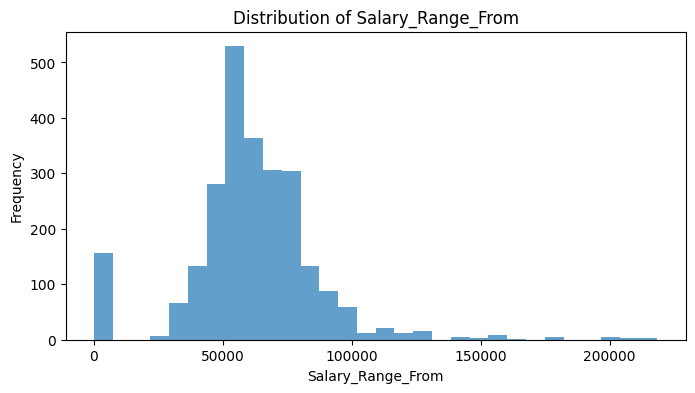

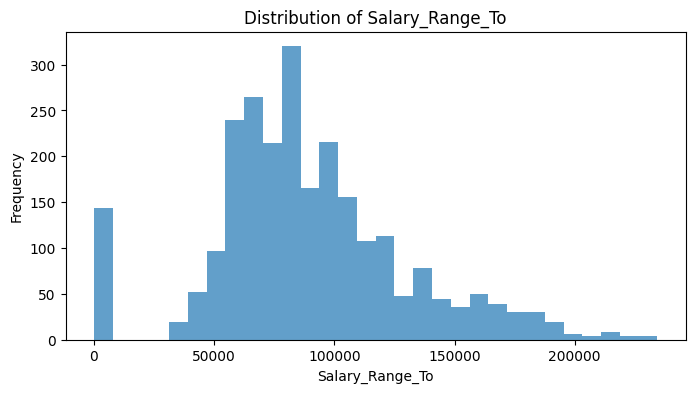

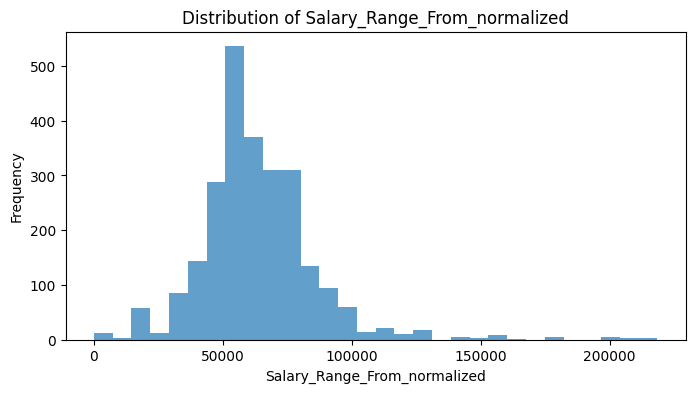

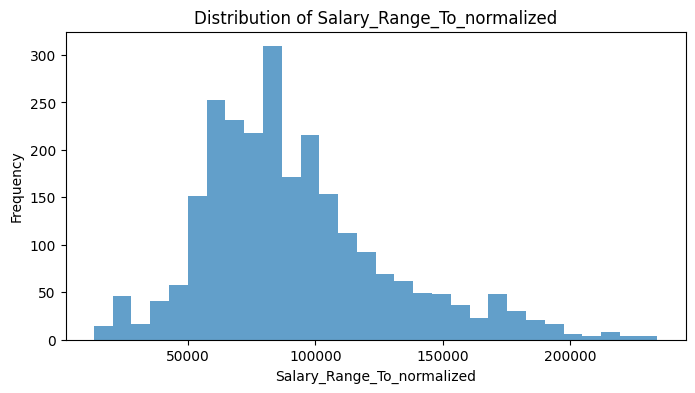

In [835]:
import matplotlib.pyplot as plt
for col in numerical_columns+['Salary_Range_From_normalized','Salary_Range_To_normalized']:
    df_pd = nyc_jobs_salary.select(col).toPandas()  # Convert to pandas
    plt.figure(figsize=(8, 4))
    plt.hist(df_pd[col], bins=30, alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

**Feature 2**

Minimum Qualification and Preferred Skills WordCloud

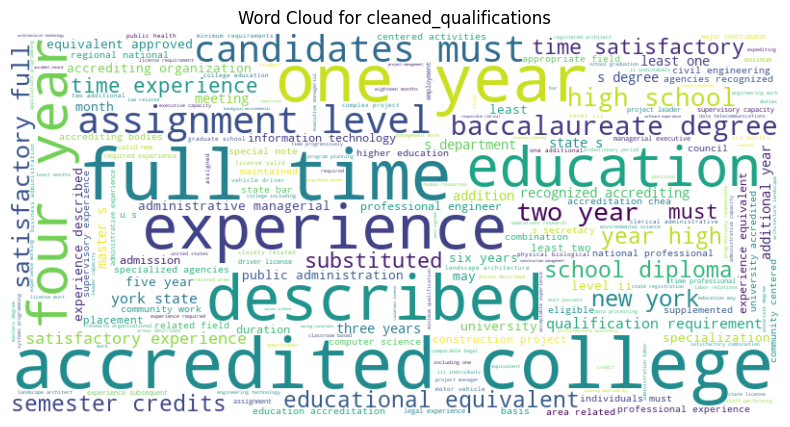

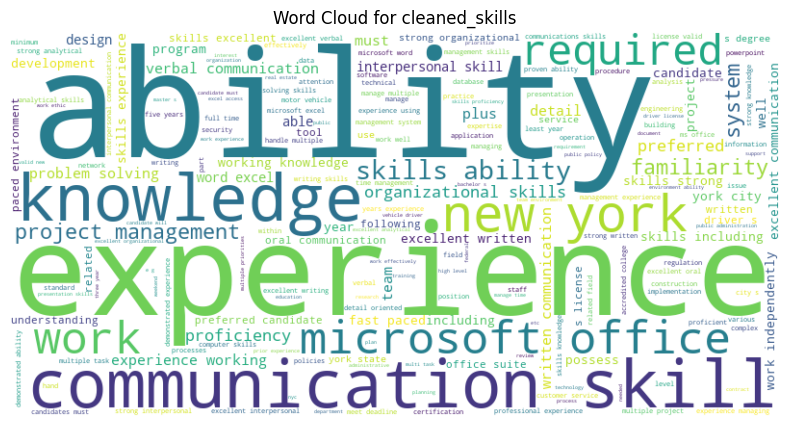

In [836]:
# Combine all the text in the MinQualReq column
def WordCloud_skills (column):
    text = " ".join(req for req in nyc_jobs_text[column])

# Create the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axes
    plt.title("Word Cloud for " + column)
    plt.show()
WordCloud_skills('cleaned_qualifications')
WordCloud_skills('cleaned_skills')

In [837]:
nyc_jobs_text = nyc_jobs_salary.select("Minimum_Qual_Requirements",'Preferred_Skills').toPandas()

In [838]:
nyc_jobs_text

,Minimum_Qual_Requirements,Preferred_Skills
0,(1) Five years of full-time satisfactory exper...,Knowledge of test and fiber splicing equipment...
1,Qualification Requirements 1. There are no fo...,Experience with horticultural maintenance; abi...
2,1. A baccalaureate degree from an accredited c...,â€¢At least 2 yearsâ€™ professional experience...
3,While there are no formal education or experie...,1.\tOffice Automation. 2.\tUnderstanding of fi...
4,"""1. A baccalaureate degree from an accredited ...",â€¢Ability to prioritize among competing needs...
...,...,...
2501,"""1. A baccalaureate degree from an accredited ...",Preferred Skills: â€¢\tExperience with Financ...
2502,1. An associate degree from an accredited coll...,The ideal candidate will possess the following...
2503,"""1. Admission to the New York State Bar; and e...",1.\tProblem Solver: Exercises independent jud...
2504,1. There are no formal education or experience...,â€¢\tExcellent time management. â€¢\tExcellen...


In [839]:
# Define stop words (add more if needed)
stop_word = set([
    'or', 'of','in','a','and','the','an','to','years','accredited','above','for','as','year','from','satisfactory',
    'time','full','one','by','equivalent','must','described','be','s','four','have','at','which','work','high','related',
    'least','credits','new','its','is','level','two','with','on','including','six','york','this','five','may','been'
    ,'however','capacity','months','valid','administration','specialized','data','professional','addition',
    'skill','ability','candidate','strong','excellent','project','all','assignment','knowledge','written'
    ,'required','experience','excel','working','preferred','education','state','system','city','organizational'
    ,'word','andor','proficiency','field','office','public','service','design','environment','team','career'
    ,'alignment','counterpart','enthusiasm','technique','initiative','caliber','developed',
    'deputy','prepare','highest','response','assumption','increasingly','agent','different','leadcontaminated'
    ,'edition','preferably','candidates','skills'])

def clensing_text(df_series):
    df = df_series.replace('[^a-zA-Z ]', ' ', regex=True)
    df = df.str.lower()
    df = df.str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with a single space
    df = df.str.strip()  # Strip leading/trailing whitespace
    return df

nyc_jobs_text['cleaned_qualifications'] = clensing_text(nyc_jobs_text['Minimum_Qual_Requirements'])
nyc_jobs_text['cleaned_skills'] = clensing_text(nyc_jobs_text['Preferred_Skills'])
    

# Function to calculate TF-IDF
def calculate_tfidf(column):
    vectorizer = CountVectorizer(stop_words=stop_word)
    X = vectorizer.fit_transform(column)
    # Get frequency of words
    word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    return word_freq

# Calculate TF-IDF for each column
qualifications_word_freq = calculate_tfidf(nyc_jobs_text['cleaned_qualifications'])
skills_word_freq = calculate_tfidf(nyc_jobs_text['cleaned_skills'])

# Sum the frequency across all rows (if you have multiple rows)
total_qualifications_freq = qualifications_word_freq.sum().reset_index()
total_qualifications_freq.columns = ['word', 'frequency']
total_qualifications_freq = total_qualifications_freq.sort_values(by='frequency', ascending=False)

total_skills_freq = skills_word_freq.sum().reset_index()
total_skills_freq.columns = ['word', 'frequency']
total_skills_freq = total_skills_freq.sort_values(by='frequency', ascending=False)

# Print results
print("Qualifications Word Frequency:\n", total_qualifications_freq)
print("\nSkills Word Frequency:\n", total_skills_freq)



Qualifications Word Frequency:
                word  frequency
265         college       4355
392          degree       3558
1316         school       2295
509     engineering       2024
144   baccalaureate       1882
...             ...        ...
909         masonry          1
710          housed          1
1363      sheetrock          1
1276        respond          1
552     evidentiary          1

[1653 rows x 2 columns]

Skills Word Frequency:
                word  frequency
2747     management       1518
868   communication       1460
2891      microsoft       1047
4878         verbal        700
2413  interpersonal        686
...             ...        ...
4733          truck          1
910     composition          1
912   comprehending          1
916    compromising          1
1056    coordinator          1

[5101 rows x 2 columns]


**Feature 3**

We need to find out what is minimum degree required for each job.

In [840]:
nyc_jobs_salary_degree=nyc_jobs_salary.withColumn("degree_derived",
                     F.when(F.lower(F.col("Minimum_Qual_Requirements")).contains("master"),"Master")
                     .when(F.lower(F.col("Minimum_Qual_Requirements")).contains("baccalaureate"),"Bachelor")
                     .when(F.lower(F.col("Minimum_Qual_Requirements")).contains("bachelor"),"Bachelor")
                     .when(F.lower(F.col("Minimum_Qual_Requirements")).contains("diploma"),"Diploma")
                     .when(F.lower(F.col("Minimum_Qual_Requirements")).contains("state bar"),"State Bar")
                     .otherwise("No Degree"))

In [841]:
nyc_jobs_salary_degree.select('degree_derived').toPandas().value_counts()

degree_derived
Bachelor          1127
Master             793
No Degree          321
State Bar          170
Diploma             95
dtype: int64

# KPIs




In [842]:
nyc_jobs_kpi=nyc_jobs_salary_degree

**What is the number of job postings per category**

In [843]:
# Count the number of null values in a specific column
null_percentage = nyc_jobs_kpi.filter(nyc_jobs_kpi['Job_Category'].isNull()).count()/nyc_jobs_kpi.count()

print(f"Percentage of null values in Job_Category: {null_percentage*100:.2f}%")


Percentage of null values in Job_Category: 0.04%


Since percentage of null values is very small, we'll drop rows with null values for this column

In [844]:
nyc_jobs_kpi_Q1 = nyc_jobs_kpi.na.drop(subset=["Job_Category"])

In [845]:
job_postings = nyc_jobs_kpi_Q1.groupBy('Job_Category') \
    .agg(F.sum('#_Of_Positions').alias('sum')) \
    .orderBy('sum', ascending=False).limit(10)

# Display the result
job_postings_pd = job_postings.toPandas().rename(columns={'sum':'No_of_Job_Postings'})
job_postings_pd

,Job_Category,No_of_Job_Postings
0,Public Safety; Inspections; & Enforcement,1083
1,Engineering; Architecture; & Planning,659
2,Building Operations & Maintenance,643
3,Technology; Data & Innovation,397
4,Health,295
5,Legal Affairs,287
6,Finance; Accounting; & Procurement,250
7,Policy; Research & Analysis,179
8,Administration & Human Resources,164
9,Constituent Services & Community Programs,141


In [846]:
def barchart_twoCategory(df_pd,x_col,y_col):
  plt.figure(figsize=(10, 6))
  ax=sns.barplot(x=x_col, y=y_col, data=df_pd)
  for container in ax.containers:
    plt.setp(container, width=0.5)
  plt.xticks(rotation=90)
  Title="distribution of Top " + y_col + " per " + x_col
  plt.title(Title)
  plt.show()

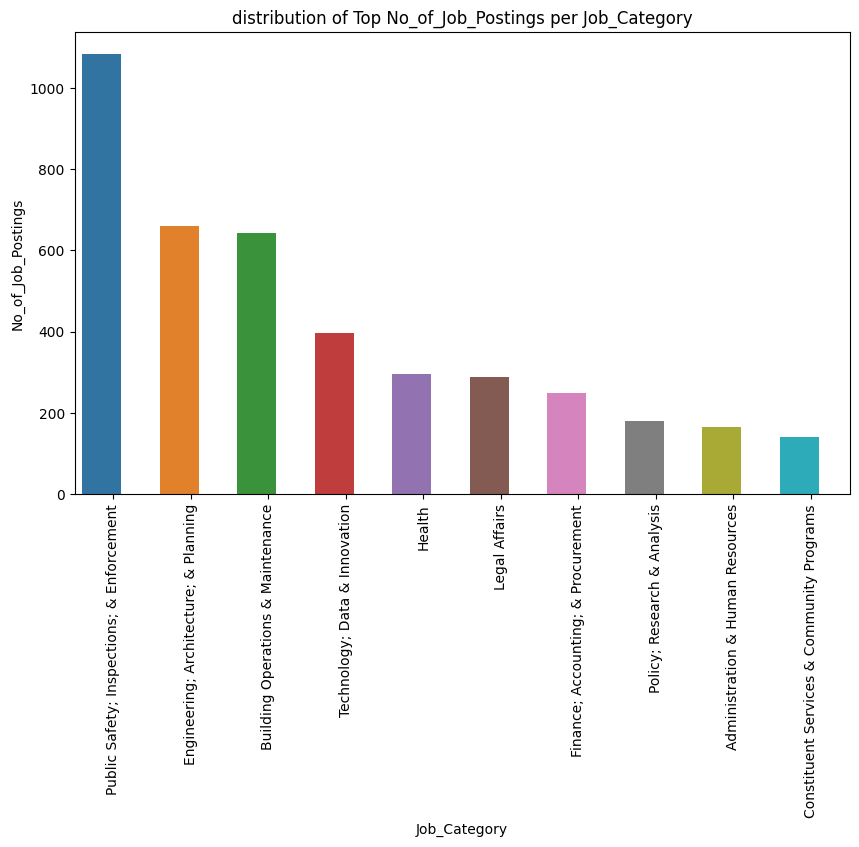

In [847]:
barchart_twoCategory(job_postings_pd,'Job_Category','No_of_Job_Postings')

**What is the salary distribution per job category?**

In [848]:
nyc_jobs_kpi_Q2 = nyc_jobs_kpi

In [849]:
def plot_salary_distribution(df):
    """
    This function generates box plots to show the salary distribution ('Salary_Range_From_normalized' and 'Salary_Range_To_normalized')
    for the top 10 job categories for both full-time (F) and part-time (P) employees.

    Parameters:
    df_updated (DataFrame): A Spark DataFrame with updated salary information.
    """
    # Step 1: Separate full-time and part-time data
    df_full_time = df.filter((F.col("Full-Time/Part-Time indicator") == "F"))
    df_part_time = df.filter((F.col("Full-Time/Part-Time indicator") == "P"))

    # Step 2: Get top 10 job categories for both full-time and part-time
    df_full = df_full_time.groupBy('Job_Category') \
        .agg(F.count('Job_Category').alias('count')) \
        .orderBy('count', ascending=False).limit(10)
    df_part = df_part_time.groupBy('Job_Category') \
        .agg(F.count('Job_Category').alias('count')) \
        .orderBy('count', ascending=False).limit(10)

    # Step 3: Join top job categories with salary data
    df_full_1 = df_full_time.join(df_full, 'Job_Category')
    df_part_1 = df_part_time.join(df_part, 'Job_Category')

    # Step 4: Convert Spark DataFrames to Pandas for plotting
    full_time_salary_from = df_full_1.select("Salary_Range_From_normalized", "Job_Category").toPandas()
    full_time_salary_from['Salary_Range_From_normalized'] = pd.to_numeric(full_time_salary_from['Salary_Range_From_normalized'], errors='coerce')

    full_time_salary_to = df_full_1.select("Salary_Range_To_normalized", "Job_Category").toPandas()
    full_time_salary_to['Salary_Range_To_normalized'] = pd.to_numeric(full_time_salary_to['Salary_Range_To_normalized'], errors='coerce')

    part_time_salary_from = df_part_1.select("Salary_Range_From_normalized", "Job_Category").toPandas()
    part_time_salary_from['Salary_Range_From_normalized'] = pd.to_numeric(part_time_salary_from['Salary_Range_From_normalized'], errors='coerce')

    part_time_salary_to = df_part_1.select("Salary_Range_To_normalized", "Job_Category").toPandas()
    part_time_salary_to['Salary_Range_To_normalized'] = pd.to_numeric(part_time_salary_to['Salary_Range_To_normalized'], errors='coerce')

    # Step 5: Plot full-time salary distribution
    draw_boxplot(full_time_salary_from,'Job_Category','Salary_Range_From_normalized')
    draw_boxplot(full_time_salary_to,'Job_Category','Salary_Range_To_normalized')
    draw_boxplot(part_time_salary_from,'Job_Category','Salary_Range_From_normalized')
    draw_boxplot(part_time_salary_to,'Job_Category','Salary_Range_To_normalized')



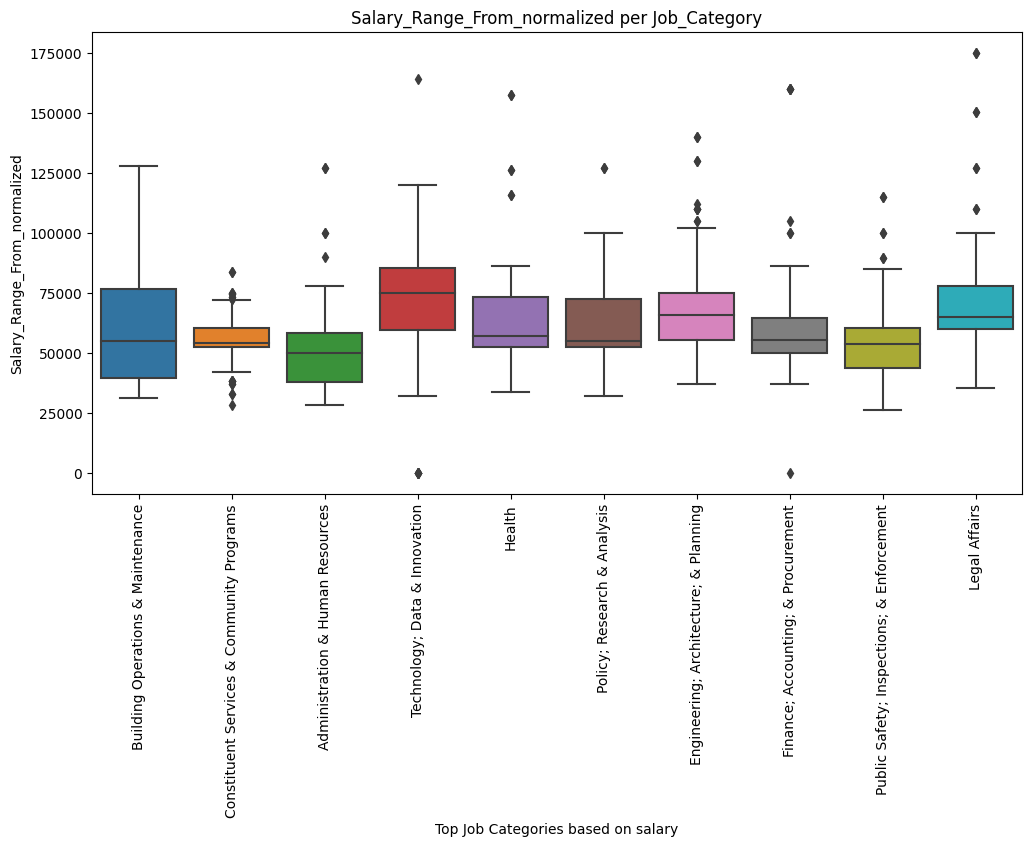

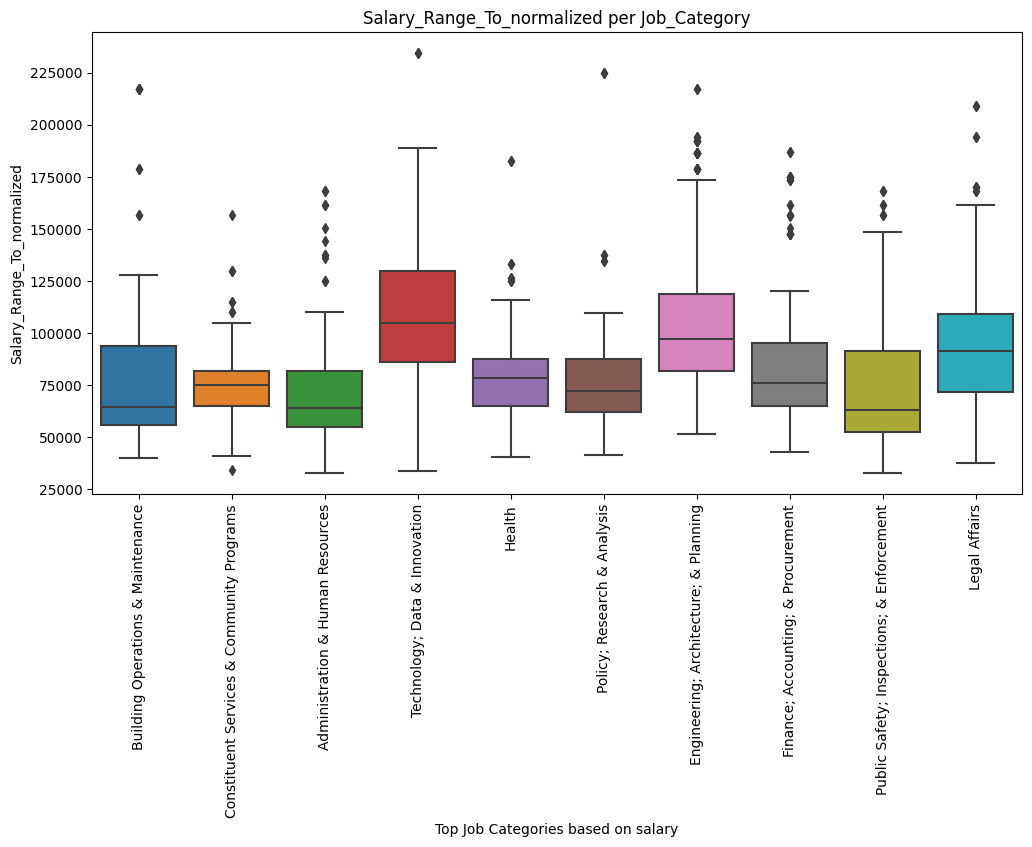

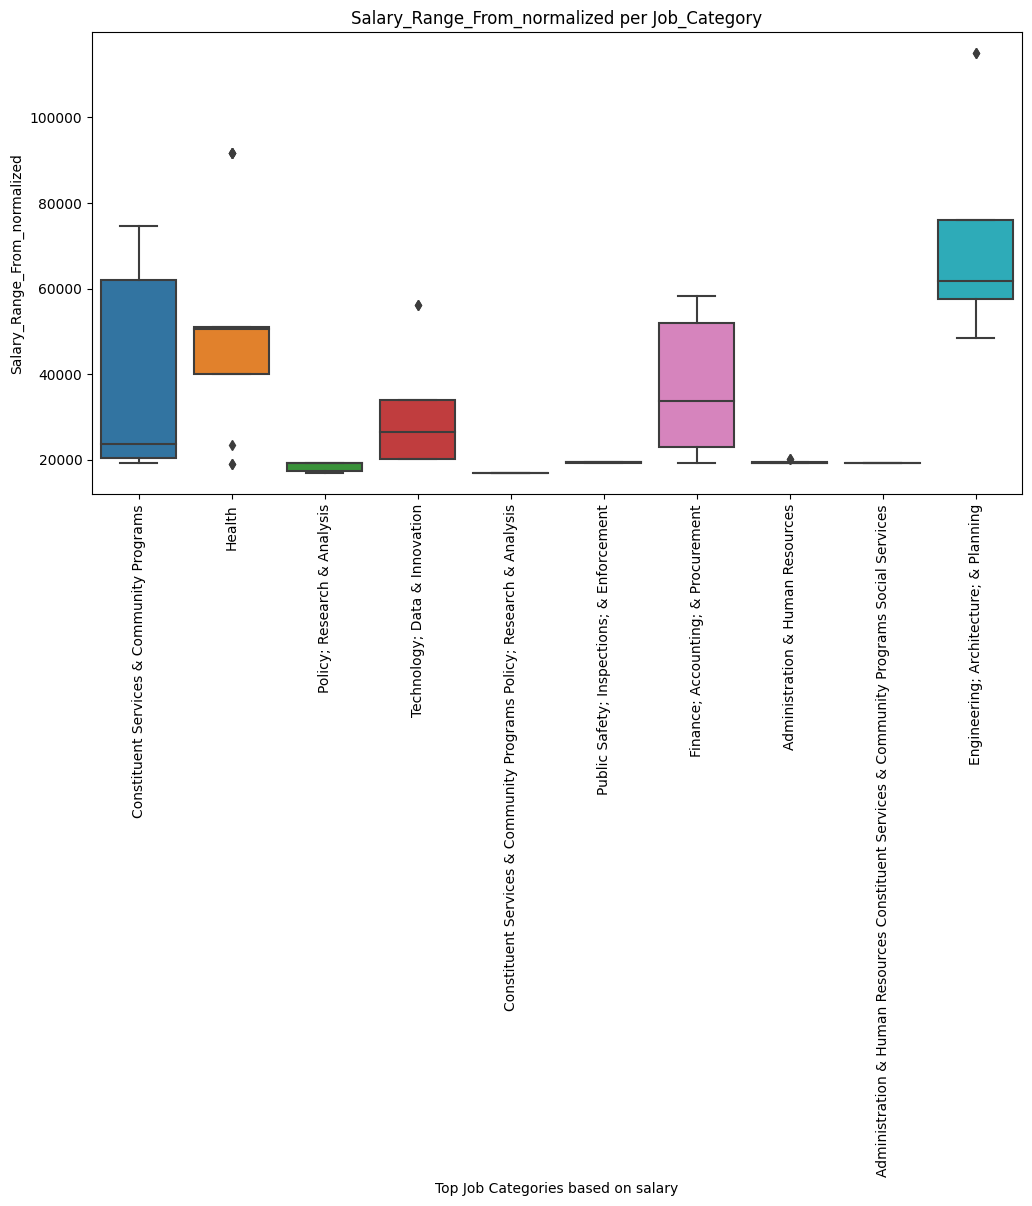

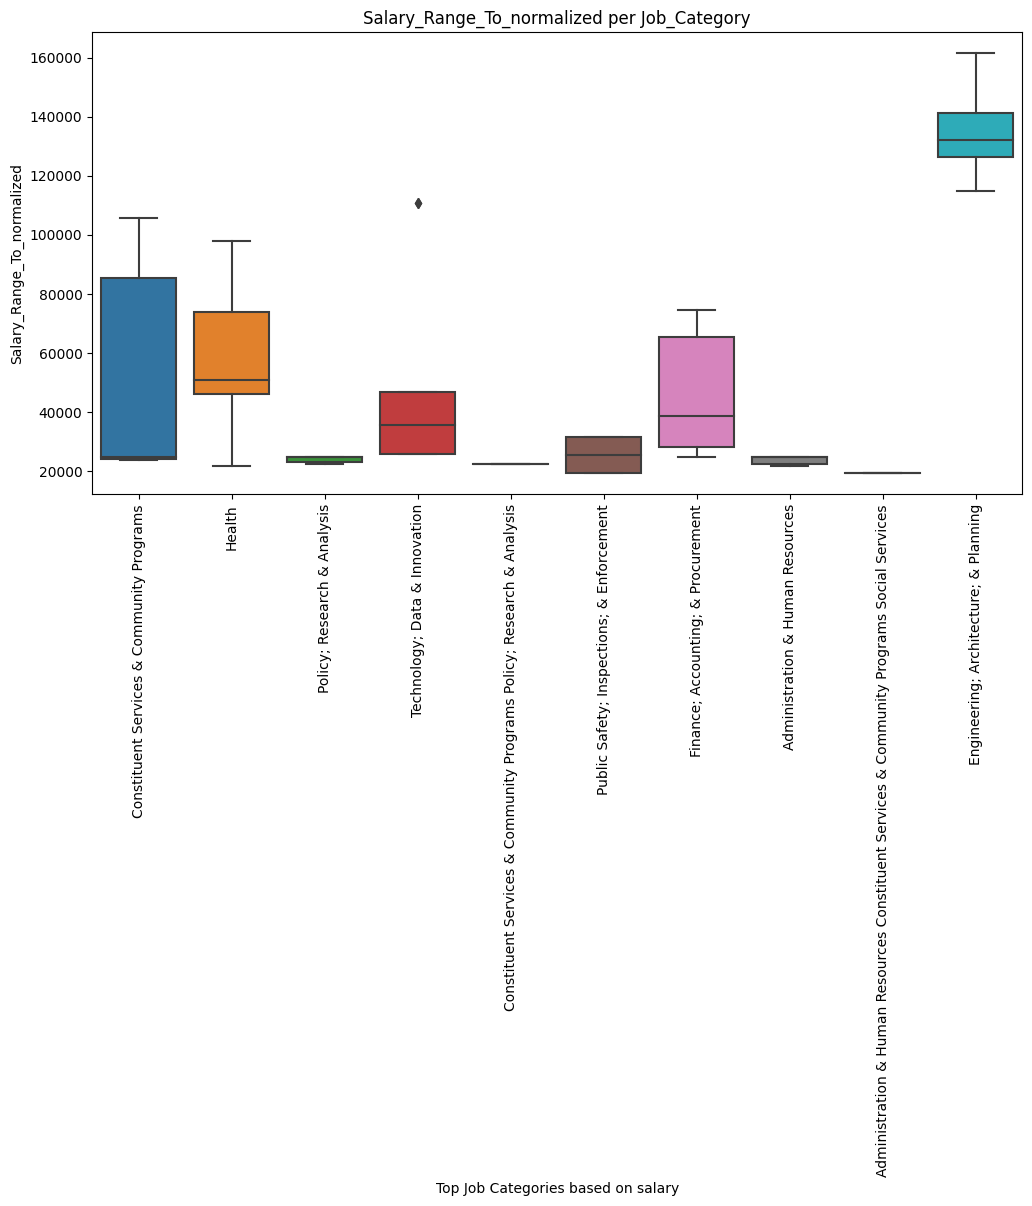

In [850]:
plot_salary_distribution(nyc_jobs_kpi_Q2)

**Is there a correlation between the higher degree and salary**

In [851]:
nyc_jobs_kpi_Q3=nyc_jobs_kpi

In [852]:
from pyspark.sql import DataFrame as SparkDataFrame
import plotly.express as px
def draw_boxplot(inp_df,x_col, y_col):
     if isinstance(inp_df,SparkDataFrame):
        inp_df_pd = inp_df.select(x_col, y_col).filter(F.col(y_col)>0).toPandas()
     elif isinstance(inp_df,pd.DataFrame):
        inp_df_pd=inp_df
#      fig = px.box(inp_df_pd, x=x_col, y=y_col, 
#                   title=f"{y_col} per {x_col}", 
#                   labels={x_col: 'Top Job Categories based on salary', y_col: y_col},
#                   hover_data=[y_col])
#      fig.show()
     plt.figure(figsize=(12, 6))
     sns.boxplot(x=x_col, y=y_col, data=inp_df_pd)
     plt.xticks(rotation=90)
     title=y_col + " per "+ x_col
     plt.xlabel('Top Job Categories based on salary')
     plt.ylabel(y_col)
     plt.title(title)
     plt.show()
     

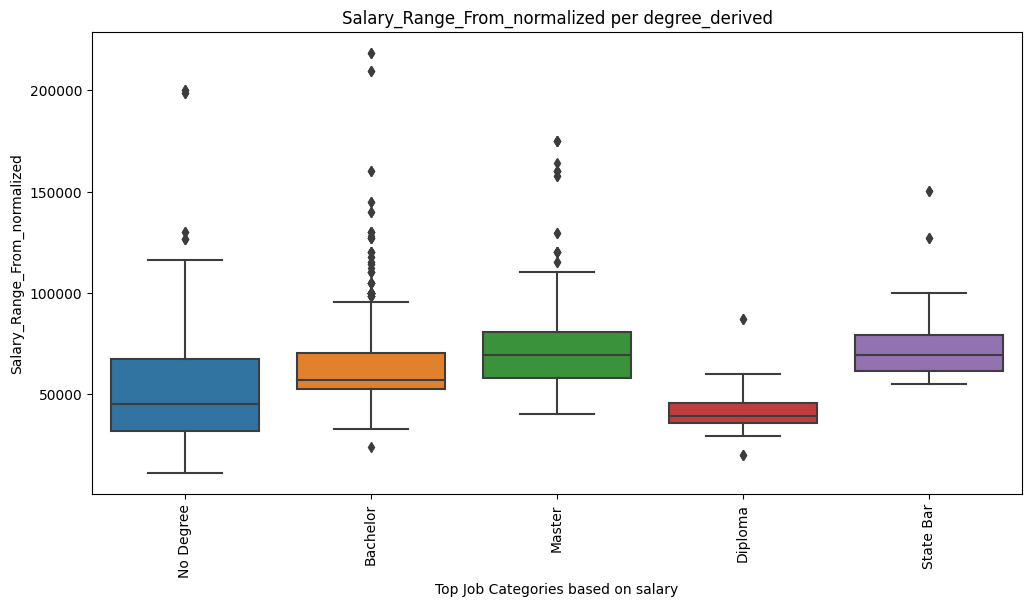

In [853]:
draw_boxplot(nyc_jobs_kpi_Q3,'degree_derived','Salary_Range_From_normalized')

In the current dataset,Diploma is referred to after completing the high school diploma whereas matriculation is enrollin
a college or university and is pursuing a course of study.

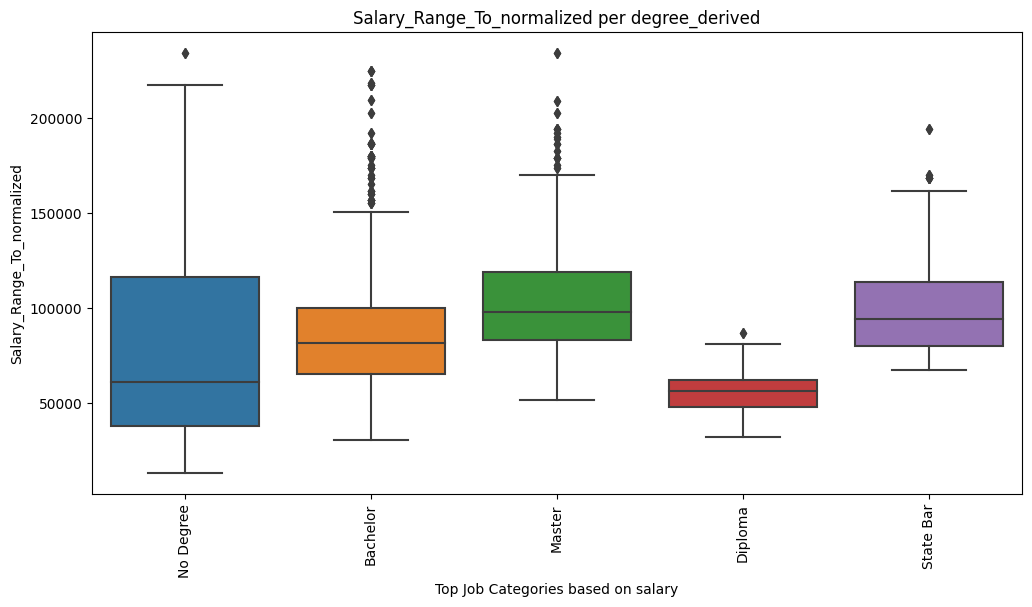

In [854]:
draw_boxplot(nyc_jobs_kpi_Q3,'degree_derived','Salary_Range_To_normalized')

**As we can see, higher the degree, higher is the salary**



In [855]:
nyc_jobs1 = nyc_jobs_salary.toPandas() 

In [856]:
nyc_jobs1['Minimum_Qual_Requirements'] = nyc_jobs1['Minimum_Qual_Requirements'].astype(str)
nyc_jobs1['degree'] = nyc_jobs1['Minimum_Qual_Requirements'].str.extract(r'(degree)')
nyc_jobs1['degree'] = nyc_jobs1['degree'].map({'degree':1,np.nan:0})
nyc_jobs1['degree'].value_counts()

1    1915
0     591
Name: degree, dtype: int64

In [857]:
nyc_jobs1.groupby('degree')['Salary_Range_From_normalized'].mean()

degree
0    55951.644382
1    65623.993995
Name: Salary_Range_From_normalized, dtype: float64

In [858]:
nyc_jobs1.groupby('degree')['Salary_Range_To_normalized'].mean()

degree
0    81329.329274
1    95203.955085
Name: Salary_Range_To_normalized, dtype: float64

# Whats the job posting having the highest salary per agency?**

In [859]:
nyc_jobs_kpi_Q4 = nyc_jobs_kpi

In [860]:
# Find the job ID with the highest salary_range_to for each agency
highest_salary_per_agency = nyc_jobs_kpi_Q4.groupBy("Agency", "Job_ID") \
    .agg(F.max("Salary_Range_To").alias("Max_Salary")) \
    .orderBy("Agency", "Max_Salary", ascending=False)
# Get the job IDs with the highest salaries
highest_salary_job_ids = highest_salary_per_agency.withColumn(
    "Rank",
    F.row_number().over(Window.partitionBy("Agency").orderBy(F.col("Max_Salary").desc()))
).filter(F.col("Rank") == 1)
# Show the results
highest_salary_job_ids=highest_salary_job_ids.orderBy('Max_Salary',ascending=False).limit(10)


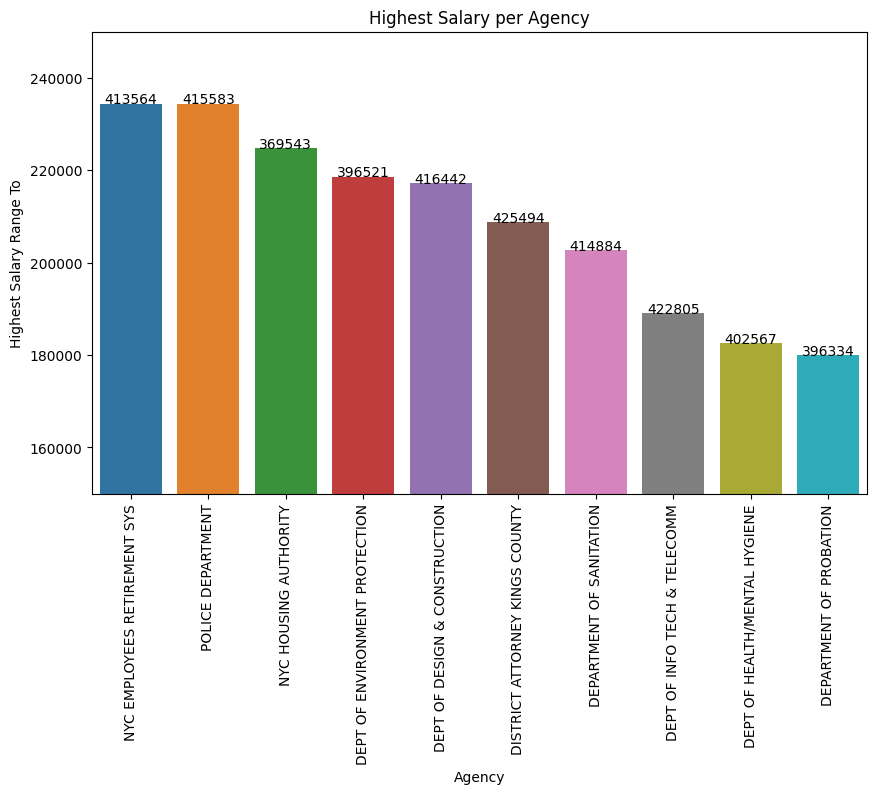

In [861]:
# Convert the result to Pandas DataFrame
highest_salary_job_ids_pd = highest_salary_job_ids.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Agency', y='Max_Salary', data=highest_salary_job_ids_pd)

# Adding Job_ID as labels
for index, row in highest_salary_job_ids_pd.iterrows():
    bar_plot.text(index, row['Max_Salary'], row['Job_ID'], color='black', ha="center")

plt.title('Highest Salary per Agency')
plt.xlabel('Agency')
plt.ylabel('Highest Salary Range To')
plt.xticks(rotation=90)
plt.ylim(150000, 250000)
plt.show()


# Whats the job positings average salary per agency for the last 2 years?**

Assumed current year is 2020 as the latest year job posting is 2019

In [862]:
nyc_jobs_kpi_Q5 = nyc_jobs_kpi

In [863]:
# Step 1: Convert 'Posting_Date' to a proper date format
df_latest = nyc_jobs_kpi_Q5.withColumn("Posting_Date", F.to_date(F.col("Posting_Date"), "yyyy-MM-dd'T'HH:mm:ss.SSS"))

# Step 2: Filter job postings for the last 2 years (730 days)
df_last_2_years = df_latest.filter(F.col('Posting_Date') >= F.date_sub(F.to_date(F.lit('2020-10-23')), 730))

# Step 3: Calculate the average salary per job posting (mean of salary_range_from and salary_range_to)
df_last_2_years = df_last_2_years.withColumn(
    "average_salary", (F.col("Salary_Range_From") + F.col("Salary_Range_To")) / 2
)
# Step 4: Group by 'Agency' and calculate the average salary per agency
average_salary_per_agency = df_last_2_years.groupBy("Agency") \
    .agg(F.round(F.avg("average_salary"),2).alias("average_salary_per_agency"))

# Step 5: Order by highest average salary (optional)
average_salary_per_agency = average_salary_per_agency.orderBy(F.desc("average_salary_per_agency")).limit(10)

# Display the results
average_salary_per_agency.show()

+--------------------+-------------------------+
|              Agency|average_salary_per_agency|
+--------------------+-------------------------+
|CONFLICTS OF INTE...|                 135000.0|
|NYC EMPLOYEES RET...|                 98739.33|
|FINANCIAL INFO SV...|                 98028.33|
| BOARD OF CORRECTION|                  96222.5|
|NYC HOUSING AUTHO...|                 89318.71|
|DEPT OF DESIGN & ...|                 87849.34|
|MAYORS OFFICE OF ...|                 87357.14|
|DEPT OF INFO TECH...|                 86325.14|
|   POLICE DEPARTMENT|                 85688.74|
|BUSINESS INTEGRIT...|                  85000.0|
+--------------------+-------------------------+



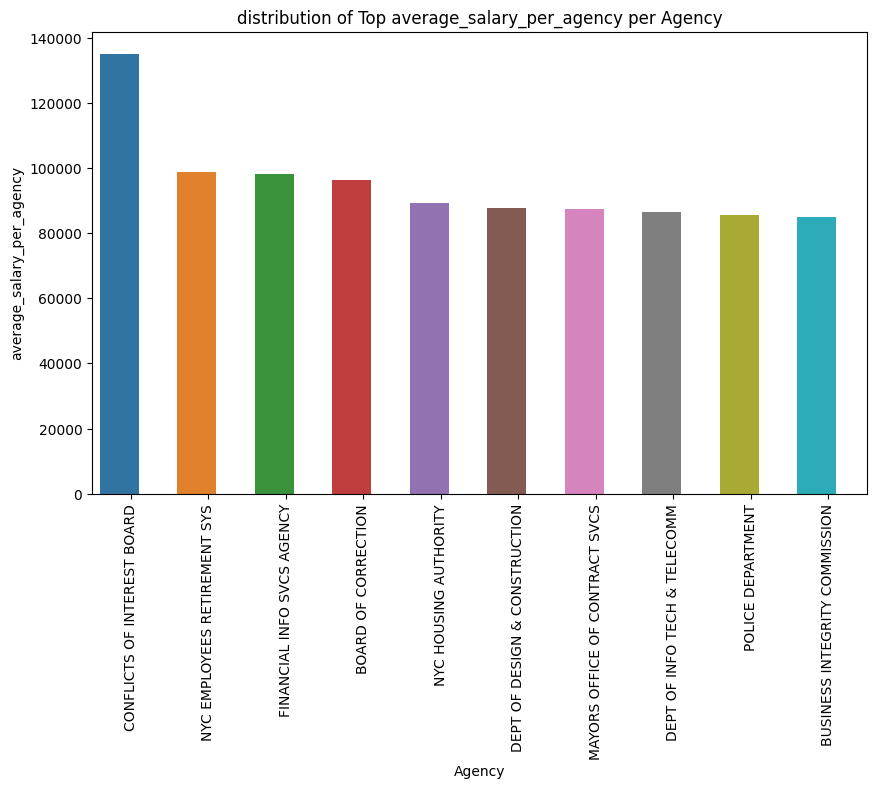

In [864]:
average_salary_pd = average_salary_per_agency.toPandas()

barchart_twoCategory(average_salary_pd,'Agency','average_salary_per_agency')


# **What are the highest paid skills in the US market?**

In [865]:
nyc_jobs_kpi_Q6 = nyc_jobs_salary

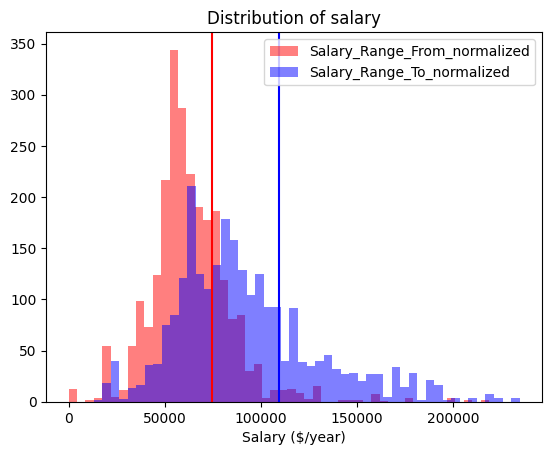

In [866]:
df_latest_pd = nyc_jobs_kpi_Q6.select('Salary_Range_From_normalized', 'Salary_Range_To_normalized').toPandas()
plt.hist(df_latest_pd['Salary_Range_From_normalized'], bins=50, alpha=  0.5, color='r', label='Salary_Range_From_normalized')
plt.hist(df_latest_pd['Salary_Range_To_normalized'],     bins=50, alpha = 0.5, color='b', label='Salary_Range_To_normalized')
plt.xlabel('Salary ($/year)')
plt.title('Distribution of salary')

plt.axvline(df_latest_pd['Salary_Range_From_normalized'].quantile(.75), color='r')
plt.axvline(df_latest_pd['Salary_Range_To_normalized'].quantile(.75), color='b')

plt.legend()
plt.show()

In [867]:
percentile_75_salary_from = nyc_jobs_kpi_Q6.approxQuantile('Salary_Range_From_normalized', [0.75], 0.01)[0]
print(f"The 75th percentile value for Salary_Range_From : {percentile_75_salary_from}")
percentile_75_salary_to = nyc_jobs_kpi_Q6.approxQuantile('Salary_Range_To_normalized', [0.75], 0.01)[0]
print(f"The 75th percentile of Salary_Range_To is: {percentile_75_salary_to}")

The 75th percentile value for Salary_Range_From : 73576.0
The 75th percentile of Salary_Range_To is: 108657.0


We can see the following results.

The 75 percentile value for "Salary Range From" is $73576.0/year.

The 75 percentile vaule for "Salary Range To " is $108657.0/year.

Therefore, we decided to identify the following words.

Words in "Minimum Qual Requirements" for jobs whose minimum salary is more than $73576.0/year.

Words in "Minimum Qual Requirements" for jobs whose maximum salary is more than $108657.0/year.

Words in "Preferred Skills" for jobs whose minimum salary is more than $73576.0/year.

Words in "Preferred Skills" for jobs whose maximum salary is more than $108657.0/year.



Added two following tags to the dataframe.

Min_Salary75: 1 for "Salary Range From Normalized" > $73576.0/year, otherwise 0.

Max_Salary75: 1 for "Salary Range To Normalized" > $108657.0/year, otherwise 0.

In [868]:
nyc_jobs_kpi_Q6=nyc_jobs_kpi_Q6.toPandas()

Assign value 1 to Max_Salary75 when particular salary is greater than 75th Percentile and value 0 if less than 75th Percentile

In [869]:
max75 = 108657.0

nyc_jobs_kpi_Q6.loc[ (nyc_jobs_kpi_Q6['Salary_Range_To_normalized'] > max75), 'Max_Salary75'] = 1
nyc_jobs_kpi_Q6.loc[~(nyc_jobs_kpi_Q6['Salary_Range_To_normalized'] > max75), 'Max_Salary75'] = 0

#nyc_jobs_kpi_Q6['Min_Salary75'] = nyc_jobs_kpi_Q6['Min_Salary75'].astype(int)
nyc_jobs_kpi_Q6['Max_Salary75'] = nyc_jobs_kpi_Q6['Max_Salary75'].astype(int)

nyc_jobs_kpi_Q6.head()

,Job_ID,Agency,Posting_Type,#_Of_Positions,Business_Title,Civil_Service_Title,Title_Code_No,Level,Job_Category,Full-Time/Part-Time indicator,...,Hours/Shift,Work_Location_1,Residency_Requirement,Posting_Date,Posting_Updated,Process_Date,Salary_Range_From_normalized,Salary_Range_To_normalized,Salary_Frequency_normalized,Max_Salary75
0,301758,DEPARTMENT OF TRANSPORTATION,Internal,2,Electrician,ELECTRICIAN,91717,0,Building Operations & Maintenance,F,...,35 Hours / Shift To Be Determined,58-50 57th Road Maspeth; N.Y. / Various,New York City residency is generally required ...,2017-08-31,2017-12-20,2019-12-17,96987.800,96987.800,Annual,0
1,376882,DEPT OF ENVIRONMENT PROTECTION,Internal,80,Seasonal City Park Worker,CITY PARK WORKER,90641,0,Building Operations & Maintenance,F,...,None,None,New York City residency is generally required ...,2018-12-20,2019-01-17,2019-12-17,33574.944,52152.464,Annual,0
2,349806,DEPARTMENT OF BUSINESS SERV.,Internal,1,PROGRAM MANAGER; INDUSTRIAL BUSINESS SERVICE P...,CONTRACT REVIEWER (OFFICE OF L,40563,1,Constituent Services & Community Programs,F,...,None,None,New York City residency is generally required ...,2018-07-10,2018-07-10,2019-12-17,53301.248,82310.800,Annual,0
3,382050,DEPT OF ENVIRONMENT PROTECTION,External,10,City Seasonal Aide,CITY SEASONAL AIDE,91406,0,Administration & Human Resources,F,...,35 hour week,59-17 Junction Blvd Corona NY; 7th Floor,New York City residency is generally required ...,2019-02-08,2019-12-11,2019-12-17,31200.000,39041.600,Annual,0
4,392327,DEPARTMENT OF BUSINESS SERV.,External,1,DIRECTOR; WORKFORCE1 CANDIDATE SERVICES,ADMINISTRATIVE BUSINESS PROMOT,10009,M2,Constituent Services & Community Programs,F,...,None,None,New York City residency is generally required ...,2019-04-29,2019-04-29,2019-12-17,72035.392,90147.200,Annual,0


Created two new columns MinQualReq and MinQualReq after cleaning it

In [879]:
nyc_jobs_kpi_Q6['Minimum_Qual_Requirements'] = nyc_jobs_kpi_Q6['Minimum_Qual_Requirements'].astype(str)
nyc_jobs_kpi_Q6['Preferred_Skills'] = nyc_jobs_kpi_Q6['Preferred_Skills'].astype(str)
nyc_jobs_kpi_Q6['MinQualReq'] = clensing_text(nyc_jobs_kpi_Q6['Minimum_Qual_Requirements'])
nyc_jobs_kpi_Q6['PrefSkills'] = clensing_text(nyc_jobs_kpi_Q6['Preferred_Skills'])

In [880]:
nyc_jobs_kpi_Q6

,Job_ID,Agency,Posting_Type,#_Of_Positions,Business_Title,Civil_Service_Title,Title_Code_No,Level,Job_Category,Full-Time/Part-Time indicator,...,Residency_Requirement,Posting_Date,Posting_Updated,Process_Date,Salary_Range_From_normalized,Salary_Range_To_normalized,Salary_Frequency_normalized,Max_Salary75,MinQualReq,PrefSkills
0,301758,DEPARTMENT OF TRANSPORTATION,Internal,2,Electrician,ELECTRICIAN,91717,0,Building Operations & Maintenance,F,...,New York City residency is generally required ...,2017-08-31,2017-12-20,2019-12-17,96987.800,96987.800,Annual,0,five years of full time satisfactory experienc...,knowledge of test and fiber splicing equipment...
1,376882,DEPT OF ENVIRONMENT PROTECTION,Internal,80,Seasonal City Park Worker,CITY PARK WORKER,90641,0,Building Operations & Maintenance,F,...,New York City residency is generally required ...,2018-12-20,2019-01-17,2019-12-17,33574.944,52152.464,Annual,0,qualification requirements there are no formal...,experience with horticultural maintenance abil...
2,349806,DEPARTMENT OF BUSINESS SERV.,Internal,1,PROGRAM MANAGER; INDUSTRIAL BUSINESS SERVICE P...,CONTRACT REVIEWER (OFFICE OF L,40563,1,Constituent Services & Community Programs,F,...,New York City residency is generally required ...,2018-07-10,2018-07-10,2019-12-17,53301.248,82310.800,Annual,0,a baccalaureate degree from an accredited coll...,at least years professional experience includi...
3,382050,DEPT OF ENVIRONMENT PROTECTION,External,10,City Seasonal Aide,CITY SEASONAL AIDE,91406,0,Administration & Human Resources,F,...,New York City residency is generally required ...,2019-02-08,2019-12-11,2019-12-17,31200.000,39041.600,Annual,0,while there are no formal education or experie...,office automation understanding of filing orga...
4,392327,DEPARTMENT OF BUSINESS SERV.,External,1,DIRECTOR; WORKFORCE1 CANDIDATE SERVICES,ADMINISTRATIVE BUSINESS PROMOT,10009,M2,Constituent Services & Community Programs,F,...,New York City residency is generally required ...,2019-04-29,2019-04-29,2019-12-17,72035.392,90147.200,Annual,0,a baccalaureate degree from an accredited coll...,ability to prioritize among competing needs an...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,426041,HOUSING PRESERVATION & DVLPMNT,Internal,1,Administration & Internal Compliance - Budget ...,COMMUNITY COORDINATOR,56058,0,Finance; Accounting; & Procurement,F,...,New York City residency is generally required ...,2019-12-13,2019-12-13,2019-12-17,54100.000,62215.000,Annual,0,a baccalaureate degree from an accredited coll...,preferred skills experience with financial man...
2502,424144,LAW DEPARTMENT,Internal,1,Executive Assistant,LEGAL SECRETARIAL ASSISTANT AL,1022A,3,Administration & Human Resources Legal Affairs,F,...,New York City residency is generally required ...,2019-12-04,2019-12-04,2019-12-17,50000.000,50000.000,Annual,0,an associate degree from an accredited college...,the ideal candidate will possess the following...
2503,424563,NYC HOUSING AUTHORITY,External,1,Senior Monitoring and Reporting Manager,AGENCY ATTORNEY,30087,3,Legal Affairs,F,...,NYCHA has no residency requirements.,2019-12-12,2019-12-13,2019-12-17,79620.000,117541.000,Annual,1,admission to the new york state bar and either...,problem solver exercises independent judgement...
2504,425605,DISTRICT ATTORNEY KINGS COUNTY,Internal,3,Clerk,COMMUNITY ASSISTANT,56056,0,Legal Affairs,F,...,New York City residency is generally required ...,2019-12-11,2019-12-11,2019-12-17,37398.000,37398.000,Annual,0,there are no formal education or experience re...,excellent time management excellent communicat...


CASE 1: 'Minimum quality requirements' for jobs with Maximum salary.

In [872]:
def calc_tfidf(docs, count, tfidf):
    bag = count.fit_transform(docs)
    t = tfidf.fit_transform(bag)
    return bag, t

def conc_text(texts, flags):
    pos = ""
    neg = ""
    for (t,f) in zip(texts.values, flags.values):
        if f >0:
            pos = pos + t + " "
        else:
            neg = neg + t + " "
    
    return [pos,neg]

tfidf = TfidfTransformer(use_idf = True, norm ='l2', smooth_idf = True)
count = CountVectorizer()

docs1 = conc_text(nyc_jobs_kpi_Q6['MinQualReq'], nyc_jobs_kpi_Q6['Max_Salary75'])
bag1, tfidf1 = calc_tfidf(docs1, count, tfidf)

In [873]:
bag1.shape

(2, 5199)

In [874]:
print(tfidf1.toarray())

[[0.00000000e+00 4.30978288e-04 2.75980141e-03 ... 0.00000000e+00
  0.00000000e+00 3.06644601e-04]
 [1.88413229e-04 0.00000000e+00 1.07246052e-03 ... 1.88413229e-04
  9.42066146e-05 2.48006494e-03]]


Then integrate vocabulary and tf-idf values into the same dataframe.

In [875]:
def stats(count, tfidf):
    df1 = pd.DataFrame(list(count.vocabulary_.items()),columns=['word','id'])
    df1 = df1.sort_values('id').reset_index()
    dfx = pd.DataFrame(tfidf.toarray().T)
    dfx.columns = ['tf-idf for high salary', 'tf-idf for low salary']
    df1 = pd.concat([df1, dfx], axis=1)
    df1['diff'] = df1['tf-idf for high salary']- df1['tf-idf for low salary']
    return df1

df1 = stats(count,tfidf1)

In [876]:
df1.nlargest(20,'diff')

,index,word,id,tf-idf for high salary,tf-idf for low salary,diff
1790,53,experience,1790,0.241943,0.181179,0.060764
3209,6,of,3209,0.294992,0.254575,0.040417
5189,52,years,5189,0.074668,0.034520,0.040148
2800,55,management,2800,0.093067,0.061063,0.032003
3691,54,project,3691,0.055503,0.031369,0.024133
4644,173,technical,4644,0.038331,0.018969,0.019361
4172,179,security,4172,0.025605,0.007641,0.017964
1015,186,construction,1015,0.037871,0.020310,0.017561
1340,300,development,1340,0.034344,0.019572,0.014772
4407,631,staff,4407,0.022385,0.009384,0.013001


In [877]:
docs2 = conc_text(nyc_jobs_kpi_Q6['MinQualReq'], nyc_jobs_kpi_Q6['Max_Salary75'])
bag2, tfidf2 = calc_tfidf(docs2, count, tfidf)
df2 = stats(count, tfidf2)
df2.nlargest(20,'diff')

,index,word,id,tf-idf for high salary,tf-idf for low salary,diff
1790,53,experience,1790,0.241943,0.181179,0.060764
3209,6,of,3209,0.294992,0.254575,0.040417
5189,52,years,5189,0.074668,0.034520,0.040148
2800,55,management,2800,0.093067,0.061063,0.032003
3691,54,project,3691,0.055503,0.031369,0.024133
4644,173,technical,4644,0.038331,0.018969,0.019361
4172,179,security,4172,0.025605,0.007641,0.017964
1015,186,construction,1015,0.037871,0.020310,0.017561
1340,300,development,1340,0.034344,0.019572,0.014772
4407,631,staff,4407,0.022385,0.009384,0.013001


Consideration: 
We found a lot of words related to management (managerial, executive, administrative, management)
There are also some words related to engineering (engineering, engineer, data, computer,construction)


CASE 2: Preferred skills for jobs with maximum salary

In [881]:
docs4 = conc_text(nyc_jobs_kpi_Q6['PrefSkills'], nyc_jobs_kpi_Q6['Max_Salary75'])
bag4, tfidf4 = calc_tfidf(docs4, count, tfidf)
df4 = stats(count, tfidf4)
df4.nlargest(20,'diff')

,index,word,id,tf-idf for high salary,tf-idf for low salary,diff
1790,53,experience,1790,0.241943,0.181179,0.060764
3209,6,of,3209,0.294992,0.254575,0.040417
5189,52,years,5189,0.074668,0.034520,0.040148
2800,55,management,2800,0.093067,0.061063,0.032003
3691,54,project,3691,0.055503,0.031369,0.024133
4644,173,technical,4644,0.038331,0.018969,0.019361
4172,179,security,4172,0.025605,0.007641,0.017964
1015,186,construction,1015,0.037871,0.020310,0.017561
1340,300,development,1340,0.034344,0.019572,0.014772
4407,631,staff,4407,0.022385,0.009384,0.013001


Consideration: 
We found a lot of words related to management (management, managerial,administrative)
We also have many words related to engineering (security,technical, azure, engineering,web design,construction)

In [882]:
class TestDataFunctions(unittest.TestCase):
     @classmethod
     def setUpClass(cls):
        # Create a Spark session
        cls.spark = spark
        # Create DataFrame for testing
        cls.df = nyc_jobs_raw
#      def test_dist_categorical(self):
#         """Test the dist_categorical function for plotting."""
#         # Here you can simply check that the function runs without error
#         for col in categorical_columns:  # Replace with your categorical column names
#             try:
#                 dist_categorical(self.df, col, 10)  # Should not raise an error
#             except Exception as e:
#                 self.fail(f"dist_categorical raised an error: {e}")
     def test_convert_salary_to_annual(self):
        """Test the convert_salary_to_annual function."""
        result_df = convert_salary_to_annual(self.df)
        #result_df.show()  # Show the results for visual verification

        # You can add assertions here to check specific expected values
        # Example: Check that normalized salary range columns exist
        self.assertIn("Salary_Range_From_normalized", result_df.columns)
        self.assertIn("Salary_Range_To_normalized", result_df.columns) 
        self.assertFalse(result_df.filter(result_df["Salary_Range_From_normalized"].isNull()).count() > 0)
        self.assertFalse(result_df.filter(result_df["Salary_Range_To_normalized"].isNull()).count() > 0)
        
     def test_value_counts_multiple_columns(self):
        counts = value_counts_multiple_columns(self.df, ["Job_Category","Agency"])
        self.assertEqual(len(counts), 2)
        self.assertIn("Agency", counts)
        
#      def test_dist_categorical(self):
#         # This function produces a plot; no assertion needed, just checking for errors
#         try:
#             dist_categorical(self.df, "Job_Category", 2)
#         except Exception as e:
#             self.fail(f"dist_categorical raised an error: {e}")
            
     def test_cleaning_text(self):
        sample_series = pd.Series(["Hello World!", "Python & Data Science", "Test 123"])
        cleaned = clensing_text(sample_series)
        self.assertEqual(cleaned[0], "hello world")
        self.assertEqual(cleaned[1], "python data science")
        self.assertEqual(cleaned[2], "test")
    

In [883]:
if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.745s

OK


In [884]:
@classmethod
def tearDownClass(cls):
    cls.spark.stop() 